# Custom State
Node(Agent)간에 공유되는 상태정보를 커스터마이징할수 있다.

**최신 장소정보 공유**
- tool 장소검색api: naver/kakao/google map api(키워드 검색기반)
- tool 자연어 -> 검색을 위한 키워드추출
    - 나 여기 독산동인데, 여기 괜찮은 까페 추천해줘 -> 독산동 까페

In [2]:
%pip install -Uq langchain langchain-openai langgraph

Note: you may need to restart the kernel to use updated packages.


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGSMITH_API_KEY'] = os.getenv('langsmith_key')
os.environ['LANGSMITH_PROJECT'] = 'skn23-langchain'
os.environ['OPENAI_API_KEY'] = os.getenv("openai_key")
KAKAO_API_KEY = os.getenv("KAKAO_API_KEY")

## 카카오 장소검색 도구

https://developers.kakao.com/docs/latest/ko/local/dev-guide#search-by-keyword

In [7]:
from langchain.tools import tool
import requests
from pprint import pprint
from typing import List, TypedDict

class KakaoPlace(TypedDict):
    name: str
    address: str
    url: str

@tool
def kakao_place_search(query: str) -> List[KakaoPlace]:
    """
    카카오 장소검색 API를 호출하기 위한 도구
    Args:
        query: 검색어(키워드 기반)
    Returns:
        검색 결과
    """
    url = 'https://dapi.kakao.com/v2/local/search/keyword.json'
    headers = {
        'Authorization': f'KakaoAK {KAKAO_API_KEY}'
    }
    params = {
        'query': query,
        'size': 5
    }
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    data = data['documents']

    return [
        {
            'name': place['place_name'],
            'address': place['address_name'],
            'url': place['place_url']
        }
        for place in data
    ]

pprint(kakao_place_search.invoke({'query': '독산역 맛집'}))

[{'address': '서울 금천구 가산동 685',
  'name': '도원',
  'url': 'http://place.map.kakao.com/1713311171'},
 {'address': '서울 금천구 독산동 1006-187',
  'name': '고향통닭',
  'url': 'http://place.map.kakao.com/236210908'},
 {'address': '서울 금천구 가산동 673',
  'name': '히나타',
  'url': 'http://place.map.kakao.com/1788547704'},
 {'address': '서울 금천구 가산동 691-3',
  'name': '천우돈',
  'url': 'http://place.map.kakao.com/1425439504'},
 {'address': '서울 금천구 가산동 680',
  'name': '좋은데',
  'url': 'http://place.map.kakao.com/382341238'}]


## 키워드 추출 도구

In [ ]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import PromptTemplate

llm = init_chat_model('openai:gpt-4.1-mini')

@tool
def extract_keyword(user_request: str) -> str:  # 사용자 요청을 장소검색 키워드로 변환하는 도구
    """
    사용자 요청에서 장소검색API를 사용하기 위한 짧고 명확한 키워드를 추출하는 도구
    장소검색도구(kakao_place_search)를 사용하기 전에 사용자의 요청을 먼저 변환하세요.
    """
    prompt = PromptTemplate.from_template('''
당신은 사용자의 요청을 장소검색에 필요한 키워드로 변환하는 전문가입니다.
장문의 사용자 요청에서 키워드를 한 문장으로 추출해주세요.
- 키워드는 띄워쓰기로 구분된 한 문장이어야 합니다.
- 다른 설명은 하지말고, 키워드만 추출합니다.

[사용자요청]
{user_request}


[예시]
- 여기 독산동인데, 소문난 맛집좀 알려줘봐 -> 독산동 맛집
- 부산 핫플 좀 알려줘봐 -> 부산 맛집

[금지어]
- 소문난
- 핫플
''')
    chain = prompt | llm
    response = chain.invoke({'user_request': user_request})
    return response.content.strip().strip('"').strip("'")  # 응답 텍스트에서 불필요한 따옴표, 공백 제거

In [15]:
print(extract_keyword.invoke('여기 독산동인데, 소문난 맛집좀 알려줘봐'))  # 지역+의도 키워드 추출
print(extract_keyword.invoke('이따 명동 갈건데, 맛집 리스트 좀 뽑아줘'))  # 장소 기반 맛집 키워드
print(extract_keyword.invoke('부산 핫플 좀 알려줘봐'))  # 금지어 제거 후 키워드
print(extract_keyword.invoke('강남에서 디저트 어디서 먹을까?'))  # 카테고리형 키워드
print(extract_keyword.invoke('수원에 호텔 어디가 좋아?'))  # 숙박 카테고리 키워드
print(extract_keyword.invoke('경기도 하남에 맛집 좀 찾아줘'))  # 업종 검색 키워드

독산동 맛집
명동 맛집
부산 관광 명소 인기 장소
강남 디저트 맛집
수원 호텔
경기 하남 맛집


## 그래프 구성

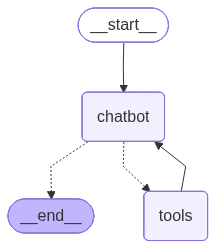

In [ ]:
# 사용자 입력 -> 키워드 추출 -> 카카오 장소검색 -> 상태(State)에 결과 저장하는 LangGraph
from langgraph.graph import StateGraph, START, END  # 그래프 구성 요소
from langgraph.graph.message import add_messages    # messages 누적 규칙
from typing import Annotated, Optional              # 타입 어노테이션
from langchain_core.messages import BaseMessage, ToolMessage  # 메시지타입
from langgraph.prebuilt import ToolNode, tools_condition  # 도구 노드 / 분기 조건

# 그래프 상태 스키마
class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]  # 메시지 누적 저장
    search_query: Optional[str]  # 검색 키워드
    search_results: Optional[List[KakaoPlace]]  # 장소검색 결과

model = init_chat_model('openai:gpt-4.1-mini')
tools = [kakao_place_search, extract_keyword]
model_with_tools = model.bind_tools(tools)      # 도구 스펙 바인딩

def chatbot(state: State):
    if isinstance(state['messages'][-1], ToolMessage):  # 직전에 도구실행 결과가 들어온 경우
        if state['messages'][-1].name == 'extract_keyword':  # 키워드 추출 도구이면
            state['search_query'] = state['messages'][-1].content    # 검색 키워드 저장
        elif state['messages'][-1].name == 'kakao_place_search':     # 장소 검색 도구이면
            state['search_results'] = state['messages'][-1].content  # 검색 결과 저장
    
    response = model_with_tools.invoke(state['messages'])  # 누적 메시지로 LLM 호출
    return {**state, 'messages': [response]}  # 상태 유지 + 새 응답 메시지 누적 반환

workflow = StateGraph(State)  # 그래프 설계 객체

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', ToolNode(tools))  # 도구실행 노드

workflow.add_edge(START, 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition)  # tool call 필요시 tools, 아니면 END로 분기
workflow.add_edge('tools', 'chatbot')  # 후속 응답 생성

graph = workflow.compile()  # 그래프 컴파일
graph

## 그래프 실행

In [ ]:
initial_state: State = {
    'messages': [('human', '하남시 맛집 추천해줘')],
    'search_query': None,    # 키워드 추출
    'search_results': None   # 장소 검색 결과
}

final_state = graph.invoke(initial_state)  # 그래프 실행
final_state

{'messages': [HumanMessage(content='하남시 맛집 추천해줘', additional_kwargs={}, response_metadata={}, id='2edf14a0-d650-4c6a-adb6-fc7f479c9669'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 139, 'total_tokens': 161, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D7any9PQg8evEUeLRui2KHeepV4VE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c4612-8aed-7792-87a0-236820e7e2f3-0', tool_calls=[{'name': 'extract_keyword', 'args': {'user_request': '하남시 맛집 추천해줘'}, 'id': 'call_sSgEGAQ1Arft1yk2qCbIkudT', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 139, 'ou

In [ ]:
from IPython.display import Markdown  # Jupyter환경에서 Markdown으로 렌더링

Markdown(final_state['messages'][-1].content)  # 마지막 메시지(모델 응답)을 Markdown으로 출력

하남시 맛집 추천드립니다:

1. 거궁 하남점 - 경기 하남시 망월동 1155 [지도보기](http://place.map.kakao.com/967998007)
2. 장수천 하남점 - 경기 하남시 감일동 211-3 [지도보기](http://place.map.kakao.com/776937410)
3. 갈비도락 미사본점 - 경기 하남시 덕풍동 26-20 [지도보기](http://place.map.kakao.com/472433650)
4. 쿠우쿠우 미사점 - 경기 하남시 망월동 1093 [지도보기](http://place.map.kakao.com/2118771306)
5. 하남미소 - 경기 하남시 신장동 522-4 [지도보기](http://place.map.kakao.com/21964583)

원하는 음식 종류나 분위기가 있으면 알려주세요. 더 맞춤 추천 드릴 수 있습니다!

## 그래프 디버깅

In [ ]:
for msg in final_state['messages']:  # 모든 메시지 순회
    msg.pretty_print()               # 메시지 역활/내용을 보기 좋은 포맷으로 출력

================================ Human Message =================================

하남시 맛집 추천해줘
================================== Ai Message ==================================
Tool Calls:
  extract_keyword (call_sSgEGAQ1Arft1yk2qCbIkudT)
 Call ID: call_sSgEGAQ1Arft1yk2qCbIkudT
  Args:
    user_request: 하남시 맛집 추천해줘
================================= Tool Message =================================
Name: extract_keyword

하남시 맛집
================================== Ai Message ==================================
Tool Calls:
  kakao_place_search (call_5uTFDscjZ9mRC481eiyNqW6J)
 Call ID: call_5uTFDscjZ9mRC481eiyNqW6J
  Args:
    query: 하남시 맛집
================================= Tool Message =================================
Name: kakao_place_search

[{"name": "거궁 하남점", "address": "경기 하남시 망월동 1155", "url": "http://place.map.kakao.com/967998007"}, {"name": "장수천 하남점", "address": "경기 하남시 감일동 211-3", "url": "http://place.map.kakao.com/776937410"}, {"name": "갈비도락 미사본점", "address": "경기 하남시 덕풍동 26-20", "url"

In [23]:
# LangGraph 스트리밍 실행 : 노드별 실행 결과를 실시간으로 확인
initial_state: State = {
    'messages': [('human', '대륭 빌딩 주변 맛집 추천해줘')],
    'search_query': None,    # 키워드 추출
    'search_results': None   # 장소 검색 결과
}

# 그래프를 스트리밍 방식으로 실행 (stream_mode='updates' 기본값으로 노드 실행이 끝날때마다 중간 결과를 전달)
for chunk in graph.stream(initial_state, stream_mode='updates'):
    for node, update in chunk.items():  # chunk (실행된 노드, 해당 업데이트) 순회
        print(f'{node} node')
        update['messages'][-1].pretty_print()  # 해당 노드에서 추가된 마지막 메시지 출력
    print()

chatbot node
================================== Ai Message ==================================
Tool Calls:
  extract_keyword (call_wHXDyZValXPxmhZFXcWTVn5y)
 Call ID: call_wHXDyZValXPxmhZFXcWTVn5y
  Args:
    user_request: 대륭 빌딩 주변 맛집
  extract_keyword (call_kHTMvMuzM3hzB48n1pQgTiS7)
 Call ID: call_kHTMvMuzM3hzB48n1pQgTiS7
  Args:
    user_request: 대륭 빌딩

tools node
================================= Tool Message =================================
Name: extract_keyword

대륭 빌딩

chatbot node
================================== Ai Message ==================================
Tool Calls:
  kakao_place_search (call_riTroSasVNtFb0aVTNDVyQC5)
 Call ID: call_riTroSasVNtFb0aVTNDVyQC5
  Args:
    query: 대륭 빌딩 맛집

tools node
================================= Tool Message =================================
Name: kakao_place_search

[{"name": "스타벅스 강남구청정문점", "address": "서울 강남구 청담동 44-12", "url": "http://place.map.kakao.com/656778644"}, {"name": "등촌샤브칼국수 문래점", "address": "서울 영등포구 문래동5가 2", "url": "http://p